<a href="https://colab.research.google.com/github/IanCramer/Arr.js-Testing/blob/master/Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import pandas as pd
import sklearn

# from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer#, TfidfTransformer
from sklearn.model_selection import GridSearchCV#, cross_val_score, train_test_split, KFold, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, classification_report, ConfusionMatrixDisplay

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Installs and imports Hugging Face sentiment analysis tools
!pip install -q transformers
from transformers import pipeline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 103.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 26.2 MB/s eta 0:00:00


In [ ]:
# Sentiment analysis using the default model (distilbert-base-uncased-finetuned-sst-2-english)
classifier = pipeline('sentiment-analysis')
result = classifier('I am very happy today!')
print(result)

# # Sentiment analysis using the 'bert-base-cased' model
# classifier = pipeline('sentiment-analysis', model='bert-base-cased', tokenizer='bert-base-cased')
# result = classifier('I am very happy today!')
# print(result)

# # Sentiment analysis using the 'distilbert-base-uncased' model
# classifier = pipeline('sentiment-analysis', model='distilbert-base-uncased', tokenizer='distilbert-base-uncased')
# result = classifier('I am very happy today!')
# print(result)

# # Sentiment analysis using the 'nlptown/bert-base-multilingual-uncased-sentiment' model for multiple languages
# classifier = pipeline('sentiment-analysis', model='nlptown/bert-base-multilingual-uncased-sentiment')
# result = classifier('Je suis très heureux aujourd\'hui!', lang='fr')
# print(result)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'label': 'POSITIVE', 'score': 0.999875545501709}]


In [1]:
# Old
def experiment_data(category, X_cols, grouped):
    # Old Path
    path = '/content/drive/MyDrive/1. School and Education/2020-2023 Northwestern/2023_Q2_Spring/CS 349 (TA)/Project/divided_datasets/'

    on_col = 'asin'
    y_col = 'awesomeness'

    # Load Training Data
    train = pd.read_json(f'{path}{category}_train.json')

    # Load Testing Data
    test1 = pd.read_json(f'{path}{category}_test1.json')
    test2 = pd.read_json(f'{path}{category}_test2.json')
    test3 = pd.read_json(f'{path}{category}_test3.json')

    if grouped:
        # Group Data
        train = group_merge_data(train[X_cols], train[['asin', y_col]].drop_duplicates(), X_cols, 'asin')
        train = train.sort_values(by='asin').reset_index(drop=True)

        test1 = group_merge_data(test1[X_cols], test1[['asin', y_col]].drop_duplicates(), X_cols, 'asin')
        test1 = test1.sort_values(by='asin').reset_index(drop=True)

        test2 = group_merge_data(test2[X_cols], test2[['asin', y_col]], X_cols, 'asin')
        test2 = test2.sort_values(by='asin').reset_index(drop=True)
        
        test3 = group_merge_data(test3[X_cols], test3[['asin', y_col]], X_cols, 'asin')
        test3 = test3.sort_values(by='asin').reset_index(drop=True)

    return train, test1, test2, test3

In [3]:
# New
def project_data(category, cols):
    # New Path
    path = '/content/drive/MyDrive/1. School and Education/2020-2023 Northwestern/2023_Q2_Spring/CS 349 (TA)/Project/divided_datasets_v2/'

    train_reviews = pd.read_json(f'{path}{category}/train/review_training.json')
    train_products = pd.read_json(f'{path}{category}/train/product_training.json')
    train = group_merge_data(train_reviews, train_products, cols, 'asin')

    test1_reviews = pd.read_json(f'{path}{category}/test1/review_test.json')
    test1_products = pd.read_json(f'{path}{category}/test1/product_test.json')
    test1 = group_merge_data(test1_reviews, test1_products, cols, 'asin')

    test2_reviews = pd.read_json(f'{path}{category}/test2/review_test.json')
    test2_products = pd.read_json(f'{path}{category}/test2/product_test.json')
    test2 = group_merge_data(test2_reviews, test2_products, cols, 'asin')

    test3_reviews = pd.read_json(f'{path}{category}/test3/review_test.json')
    test3_products = pd.read_json(f'{path}{category}/test3/product_test.json')
    test3 = group_merge_data(test3_reviews, test3_products, cols, 'asin')

    return train, test1, test2, test3


In [3]:
def group_merge_data(df1, df2, cols, on_col):
    grouped = df1.groupby(on_col).agg(lambda x: ' '.join(x.astype(str))).reset_index()
    grouped = grouped[cols]
    df2 = pd.merge(df2, grouped, on=on_col, how='left')
    return df2

In [4]:
def vectorize(df, X_cols, y_col, vectorizer=None):
    if not vectorizer:
        # Construct the Vectorizer    
        vectorizer = CountVectorizer()

        # Vectorize and Transform the data
        X_text = df[X_cols].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)
        X = vectorizer.fit_transform(X_text)
        y  = df[y_col]
        return X, y, vectorizer
    
    assert vectorizer.vocabulary_ is not None
    # Apply the vectorization and transformation from training to the data
    X_text = df[X_cols].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)
    X = vectorizer.transform(X_text)
    y = df[y_col]
    return X, y, vectorizer

In [5]:
# Perform 10-fold cross validation training that searches for optimal hyper parameters
def k_fold_cross_val_fit(model, params, X, y, k):
    grid_search = GridSearchCV(nb, params, cv=k)
    grid_search.fit(X, y)
    print("Best hyperparameters:", grid_search.best_params_)
    return grid_search.best_estimator_

In [6]:
def test(model, X, y, test_num):
    predicted = model.predict(X)
    target_names = ['not awesome', 'awesome']
    print("==== results on test set " + str(test_num) + " ====== \n ")
    print(classification_report(y, predicted, target_names=target_names))
    ConfusionMatrixDisplay.from_estimator(
        model, X, y, display_labels=target_names, xticks_rotation="vertical"
    )
    return f1_score(y, predicted, average='weighted')

In [12]:
def run_experiment(category, X_cols, y_col, model, params, grouped):
    print(f'Using a {model.__class__.__name__} with input features {X_cols} to classify {y_col} on the {category} dataset')


    # Load Data
    print("Loading Data")
    train, test1, test2, test3 = experiment_data(category, X_cols, grouped)


    # Construct the vectorizer for vectorizing text data
    print("Vectorizing")
    vectorizer = CountVectorizer()

    # Vectorize and Transform the data
    train_X, train_y, vectorizer = vectorize(train, X_cols, y_col)

    test1_X, test1_y, _ = vectorize(test1, X_cols, y_col, vectorizer)
    test2_X, test2_y, _ = vectorize(test2, X_cols, y_col, vectorizer)
    test3_X, test3_y, _ = vectorize(test3, X_cols, y_col, vectorizer)


    # Use 10 fold cross validation to find the best hyper parameters for the model
    print("Cross Validating for hyper parameter optimization")
    model = k_fold_cross_val_fit(model, params, train_X, train_y, 10)


    # Fit the model on the entier training set
    print("fitting")
    model.fit(train_X, train_y)


    # Test the model on each of the test sets
    test(model, test1_X, test1_y, 1)
    test(model, test2_X, test2_y, 2)
    test(model, test3_X, test3_y, 3)

In [8]:
# Construct a MultinomialNB Classifier
nb = MultinomialNB()
# Set the hyperparameters to be tuned during cross validation training
nb_params = {'alpha': [1*10**-10, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1.0, 2.0, 4.0, 8.0],
              'fit_prior': [True, False]
              }

In [10]:
svm = LinearSVC()
svm_params = {'C': [0.1, 1, 10],
              'gamma': [0.1, 1, 10],
              'kernel': ['linear', 'rbf']}

In [11]:
rf = RandomForestClassifier()
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

In [10]:
# Categories: ['Automotive', 'CDs_and_Vinyl', 'Cell_Phones_and_Accessories', 'Grocery_and_Gourmet_Food', 'Sports_and_Outdoors', 'Toys_and_Games']
category = 'Grocery_and_Gourmet_Food'

# Columns: 
X_cols = ['asin', 'reviewerID', 'verified', 'reviewerName', 'reviewText', 'summary']
y_col = 'awesomeness'
model = nb
params = nb_params

Using a MultinomialNB with input features ['asin', 'reviewerID', 'verified', 'reviewerName', 'reviewText', 'summary'] to classify awesomeness on the Grocery_and_Gourmet_Food dataset
Loading Data
Vectorizing
Cross Validating for hyper parameter optimization
Best hyperparameters: {'alpha': 0.1, 'fit_prior': True}
fitting
==== results on test set 1 ====== 
 
              precision    recall  f1-score   support

 not awesome       0.92      0.93      0.93     93491
     awesome       0.95      0.94      0.94    120030

    accuracy                           0.94    213521
   macro avg       0.94      0.94      0.94    213521
weighted avg       0.94      0.94      0.94    213521

==== results on test set 2 ====== 
 
              precision    recall  f1-score   support

 not awesome       0.93      0.93      0.93     62469
     awesome       0.95      0.94      0.94     79878

    accuracy                           0.94    142347
   macro avg       0.94      0.94      0.94    142347
weight

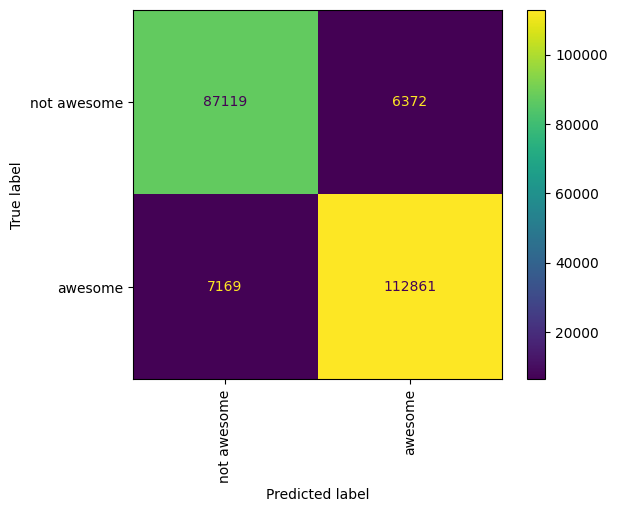

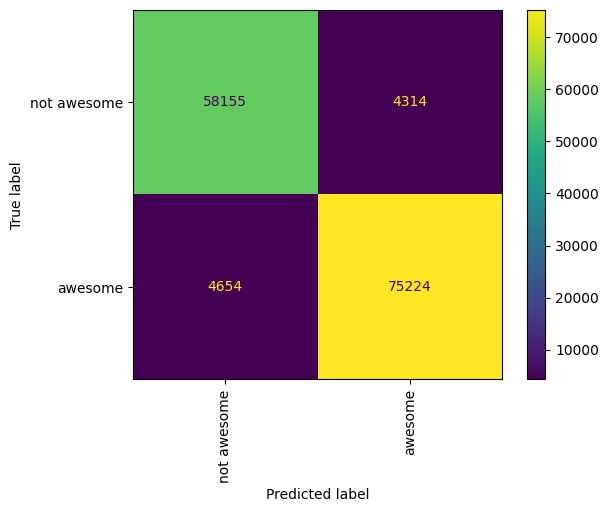

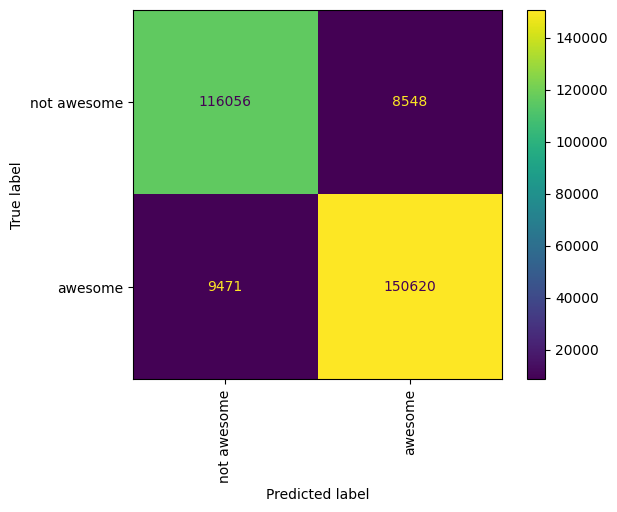

In [13]:
# Without Grouping Data
run_experiment(category, X_cols, y_col, model, params, False)

In [ ]:
# Grouped Data
run_experiment(category, X_cols, y_col, model, params, True)

Using a MultinomialNB with input features ['asin', 'reviewerID', 'verified', 'reviewerName', 'reviewText', 'summary'] to classify awesomeness on the Grocery_and_Gourmet_Food dataset
Loading Data
Vectorizing
